In [2]:
import numpy as np
from numpy import random
import copy 
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import umap
# import hdbscan
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
from collections import Counter

import statistics
from pylab import rcParams
from random import sample

In [3]:
def generate_ballot(m, p=0.5):
    return (random.rand(m)+(p-0.5)).round().astype(int)

class Cluster():
    def __init__(self, m, n, permutation_rate=0.1, p=0.5):
        self.m = m
        m = int(m * 0.95)
        self.n = n
        self.permutation_rate = permutation_rate
        self._index_map = np.array(sample(range(self.m), m))
        self._mean = generate_ballot(m, p)
        self.__create_n_voter_ballots(m)

        self._mean, tmp = np.zeros(self.m), self._mean
        self._mean[self._index_map] = tmp
        
    def __create_n_voter_ballots(self, m):
        self._ballots = np.zeros((self.n, self.m))
        for i in range(self.n):
            self._ballots[i,self._index_map] = self.__permutate_ballot(m)
        
    def __permutate_ballot(self, m):
        # point permutate the ballot up to 10 times
        new_ballot = copy.copy(self._mean)
        for _ in range(random.randint(self.permutation_rate*m+1)):
            new_ballot[random.randint(m)] = 1 - new_ballot[random.randint(m)]
            
        return new_ballot
    
    @property
    def ballots(self):
        return self._ballots
    
    @property
    def cluster_ballot(self):
        return self._mean
    
    def __repr__(self):
        return str(self._ballots)
    
    def statistics(self):
        rcParams['figure.figsize'] = 7, 4
        rcParams['figure.dpi'] = 75
        rcParams.update({'font.size': 10})
        print(f"Probability that a voter votes the same for one project compared to the cluster ballot = {1-np.mean(np.abs(self._ballots-self._mean))}")
        x,y = np.unique(self._ballots, return_counts=True, axis=0)
        print(f"Number of unique ballets in this cluster = {len(x)}")
        print(f"Number of voters that vote the cluster ballot = {max(y)}")
        plt.plot(*np.unique(np.abs(self._ballots - self._mean).sum(1), return_counts=True), '-o')
        plt.xlabel("difference between voter ballot and cluster ballot")
        plt.ylabel("number of voters")
        plt.show()
        plt.plot(self._mean*100, 'o',label="cluster ballot")
        plt.plot(self._ballots.mean(0)*100,'x',label="voters")
        plt.legend()
        plt.xlim(0,self.m)
        plt.xlabel("Projects")
        plt.ylabel("Change of approving a project(%)")
        plt.show()
        
    

In [5]:
n_clusters = 10
n_voters = 500
clusters = [Cluster(100,n_voters,1.5,0.15) for _ in range(n_clusters)]
target = np.reshape([[i]*n_voters for i in range(n_clusters)], (-1))

data = np.vstack([x.ballots for x in clusters])

Probability that a voter votes the same for one project compared to the cluster ballot = 0.71702
Number of unique ballets in this cluster = 495
Number of voters that vote the cluster ballot = 6


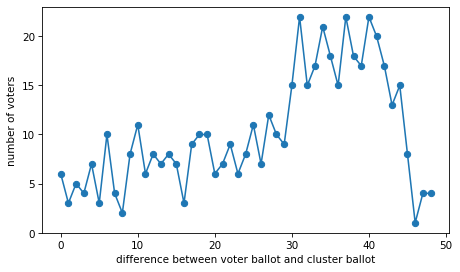

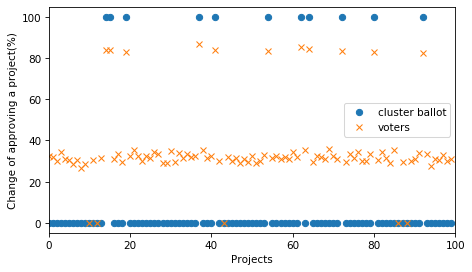

In [6]:
clusters[0].statistics()

In [7]:
k = KMeans(n_clusters).fit_predict(data)
acc = []
for i in range(n_clusters):
    one_cluster = k[i*n_voters: (i+1)*n_voters]
    occurence_count = Counter(one_cluster)
    acc.append(np.mean(one_cluster == occurence_count.most_common(1)[0][0]))

print(f"acc for each cluster: {acc} \nAvg acc: {np.mean(acc):.3f}")

acc for each cluster: [0.938, 0.938, 0.956, 0.936, 0.958, 0.928, 0.932, 0.952, 0.956, 0.93] 
Avg acc: 0.942


In [8]:
reducer = umap.UMAP(n_components=2, n_neighbors=100, metric='manhattan')
reducer.fit(data)
embedding = reducer.transform(data)
# Verify that the result of calling transform is
# idenitical to accessing the embedding_ attribute
assert(np.all(embedding == reducer.embedding_))
embedding.shape

(5000, 2)

In [9]:
kmeans = KMeans(n_clusters).fit(embedding)
k = kmeans.labels_
# mean = reducer.inverse_transform(kmeans.cluster_centers_)

acc = []
for i in range(n_clusters):
    one_cluster = k[i*n_voters: (i+1)*n_voters]
    occurence_count = Counter(one_cluster)
    acc.append(np.mean(one_cluster == occurence_count.most_common(1)[0][0]))

print(f"acc for each cluster: {acc} \nAvg acc: {np.mean(acc):.3f}")

acc for each cluster: [0.888, 0.914, 0.932, 0.934, 0.934, 0.91, 0.898, 0.936, 0.93, 0.95] 
Avg acc: 0.923


Text(0.5, 1.0, 'UMAP projection of the dataset')

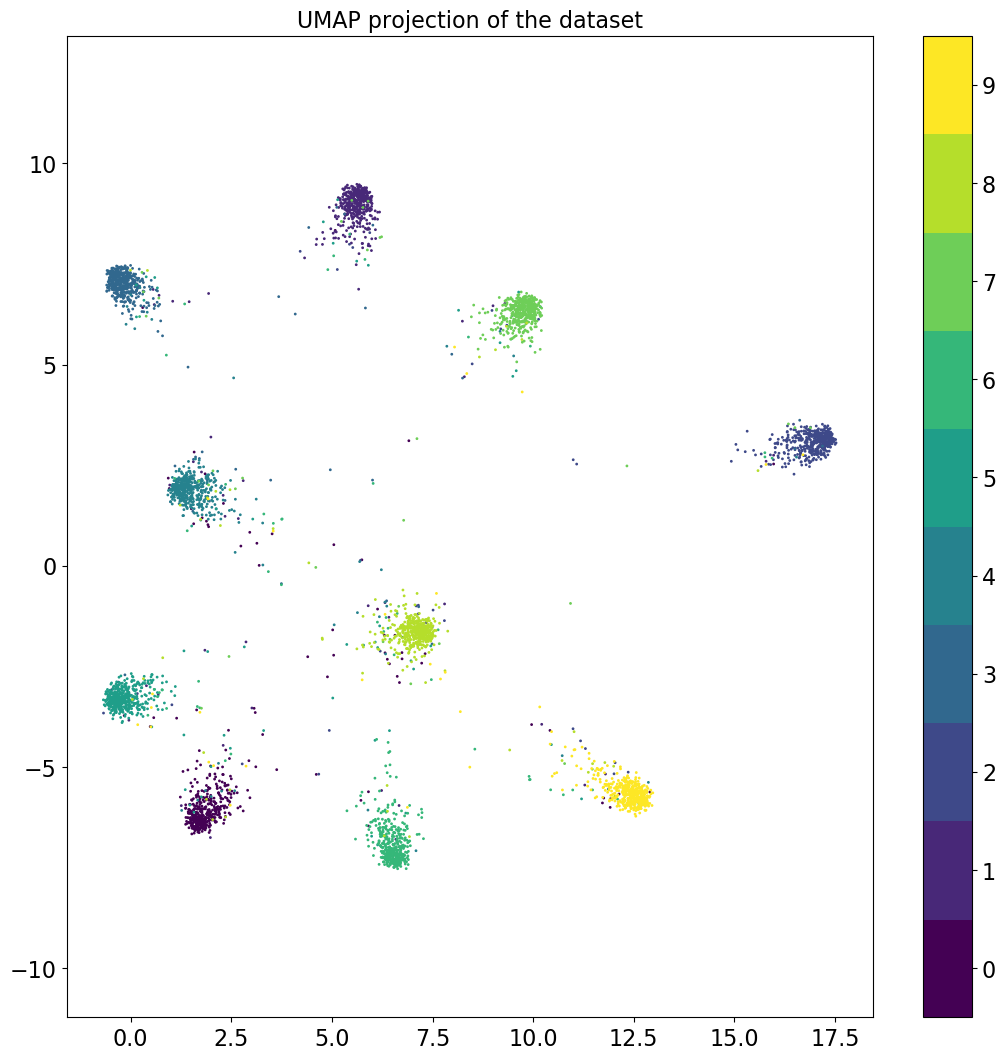

In [10]:
rcParams['figure.figsize'] = 13, 13
rcParams['figure.dpi'] = 100
rcParams.update({'font.size': 16})

plt.scatter(embedding[:, 0], embedding[:, 1], c=target, s=1)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(n_clusters+1)-0.5).set_ticks(np.arange(n_clusters))
plt.title('UMAP projection of the dataset', fontsize=16)